In [0]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

In [2]:
!git clone https://github.com/kmilo7204/Finding_Lane_Lines

Cloning into 'Finding_Lane_Lines'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 1), reused 28 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


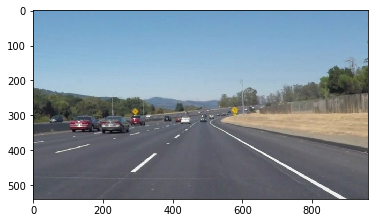

In [3]:
# Read the image to visualize each step of the script

image = cv2.imread('./Finding_Lane_Lines/test_images/solidWhiteCurve.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

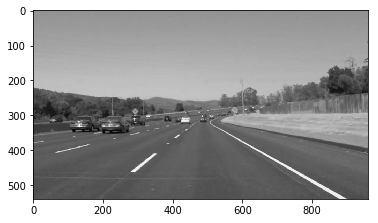

In [4]:
def gray_scale(img):
    ## Function to convert the raw image into a gray scale image
    
    # Input: Image
    # Outuput: Gray image
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray

img_gray = gray_scale(image)
plt.imshow(img_gray, cmap = 'gray')
plt.show()

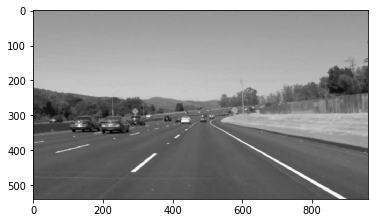

In [5]:
def gaussian_blur(img, kernel):
    ## Function to apply a Gaussian Blur filter to the gray scale image
    
    # Inputs: Gray image, Kernel's size
    # Output: Gaussian blur image
    
    img_gauss = cv2.GaussianBlur(img, (kernel, kernel), 0)
    return img_gauss

img_gauss = gaussian_blur(img_gray, kernel = 5)
plt.imshow(img_gauss, cmap = 'gray')
plt.show()

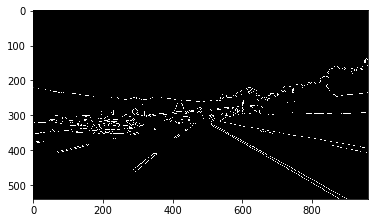

In [6]:
def canny(img):
    ## Function to apply the Canny function for edge detection
    
    # Input: Gaussian blur image
    # Outuput: Canny image
    
    img_canny = cv2.Canny(img, 50, 150)
    return img_canny
  
img_canny = canny(img_gauss)
plt.imshow(img_canny, cmap = 'gray')
plt.show()

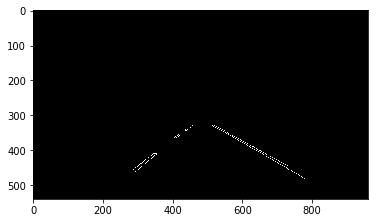

In [7]:
def ROI(img):
    ## Function to extract the region of interest (ROI)
    
    # Input: Canny image
    # Output: Cropped image
    
    height = img.shape[0]
    polygon = np.array([[(130, height), (855, height), (580, 330), (420, 330)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygon, 255)
    img_roi = cv2.bitwise_and(img, mask)
    return img_roi

img_roi = ROI(img_canny)
plt.imshow(img_roi, cmap = 'gray')
plt.show()

In [0]:
def hough_transform(img):
    ## Funtion to apply the Hough Transform and find the lines within the ROI
    
    # Input: Cropped image
    # Output: Hough vector lines
    
    # Paremeters notes: 2 Pixels, 1 Degree res and 55 Threshold
    hough_lines = cv2.HoughLinesP(img, 2, (np.pi / 180), 55, np.array([]), minLineLength = 20, maxLineGap = 3)
    return hough_lines
  
hough_lines = hough_transform(img_roi)

In [0]:
def coordinates(img, line_parameters):
    ## Function to find the line parameters (Y = mx + b)
    
    # Inputs: Raw image, Line parameters (Slope and intercept)
    # Output: Vector array (x1, y1, x2, y2)
    
    slope, intercept = line_parameters
    y1 = img.shape[0]
    y2 = (340)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    line = np.array([x1, y1, x2, y2])
    return line

In [0]:
def slope_intercept(img, lines):
    ## Function that returns one line per side, based on the average of all the lines in the image based on their slope
    
    # Inputs: Raw image, Hough vector lines
    # Output: Vector array (x1, y1, x2, y2)
    
    right = []
    left = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            line_par = np.polyfit((x1, x2), (y1, y2), 1)
            slope = line_par[0]
            intercept = line_par[1]
            if slope < 0:
                left.append((slope, intercept))
            else:
                right.append((slope, intercept))
    if left:
        left_avg = np.average(left, axis = 0)
        left_line = coordinates(img, left_avg)
    else:
        left_line = np.array([0, 0, 0, 0])

    if right:
        right_avg = np.average(right, axis = 0)
        right_line = coordinates(img, right_avg)
    else:
        right_line = np.array([0, 0, 0, 0])

    lines = np.array([left_line, right_line])
    return lines

lines = slope_intercept(image, hough_lines)

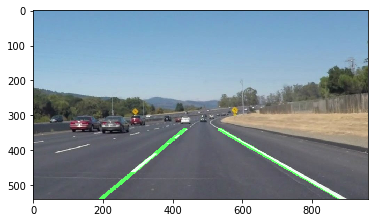

In [11]:
def disp_lines(img, lines):
    ## Function to draw the lines in a black image
    
    # Inputs: Raw image, Lines vector
    # Output: Image (Containing the lines)
    
    img_lines = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(img_lines, (x1, y1), (x2, y2), (0, 255, 0), 10)
    return img_lines
  
img_lines = disp_lines(image, lines)
img_comb = cv2.addWeighted(image, 1.0, img_lines, 1.0, 0)
plt.imshow(img_comb)
plt.show()

In [0]:
def image_processing(img):
    gray_image = gray_scale(img)
    blur_image = gaussian_blur(gray_image, 5)
    canny_image = canny(blur_image)
    ROI_image = ROI(canny_image)

    lines = hough_transform(ROI_image)
    avg_lines = slope_intercept(img,lines)
    lines_image = disp_lines(img, avg_lines)

    comb_image = cv2.addWeighted(img, 0.8, lines_image, 1.5, 1)
    return comb_image

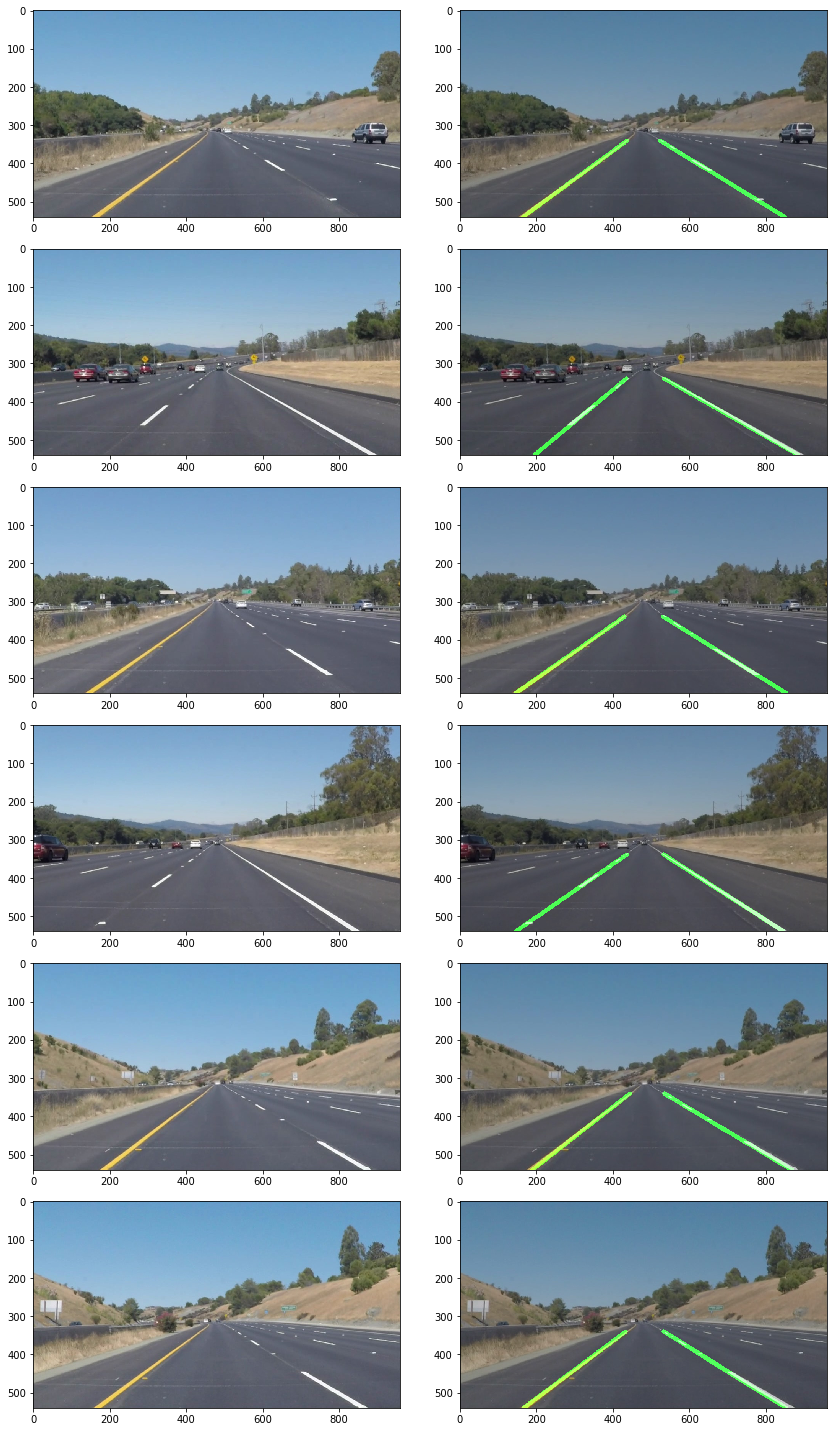

In [17]:
test_images_ls = os.listdir('./Finding_Lane_Lines/test_images')

fig, axs = plt.subplots(len(test_images_ls), 2, figsize = (12, 20))
fig.tight_layout()

idx = 0

for image in test_images_ls:

  img = mpimg.imread('./Finding_Lane_Lines/test_images/' + image)
  axs[idx][0].imshow(img) 

  comb_image = image_processing(img)
  axs[idx][1].imshow(comb_image)
  
  mpimg.imsave('./Finding_Lane_Lines/test_images_output/Lines in ' + image, comb_image)
  idx += 1

In [14]:
from moviepy.editor import VideoFileClip

WhiteRight = './Finding_Lane_Lines/test_videos_output/solidWhiteRight.mp4'

video_clip = VideoFileClip('./Finding_Lane_Lines/test_videos/solidWhiteRight.mp4')
output_clip = video_clip.fl_image(image_processing)
output_clip.write_videofile(WhiteRight, audio = False)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4038656/45929032 bytes (8.8%)8306688/45929032 bytes (18.1%)12541952/45929032 bytes (27.3%)16646144/45929032 bytes (36.2%)20889600/45929032 bytes (45.5%)25157632/45929032 bytes (54.8%)29433856/45929032 bytes (64.1%)33669120/45929032 bytes (73.3%)37961728/45929032 bytes (82.7%)42246144/45929032 bytes (92.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.
[MoviePy] >>>> Buildin

100%|█████████▉| 221/222 [00:08<00:00, 24.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Finding_Lane_Lines/test_videos_output/solidWhiteRight.mp4 



In [15]:
YellowLeft = './Finding_Lane_Lines/test_videos_output/solidYellowLeft.mp4'

video_clip = VideoFileClip('./Finding_Lane_Lines/test_videos/solidYellowLeft.mp4')
output_clip = video_clip.fl_image(image_processing)
output_clip.write_videofile(YellowLeft, audio = False)

[MoviePy] >>>> Building video ./Finding_Lane_Lines/test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video ./Finding_Lane_Lines/test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Finding_Lane_Lines/test_videos_output/solidYellowLeft.mp4 

